In [1]:
import os
from argparse import ArgumentParser

import numpy as np
import matplotlib.pyplot as plt
import wandb
import torch
from denoising_diffusion_pytorch import Unet, GaussianDiffusion, Trainer
from encoder_decoders.vq_vae_encdec import VQVAEEncoder, VQVAEDecoder
from vector_quantization import VectorQuantize
from utils import load_yaml_param_settings, get_root_dir, freeze, quantize
from einops import rearrange
import einops
import pandas as pd

from stage2 import load_pretrained_encoder_decoder_vq
from denoising_diffusion_pytorch.denoising_diffusion_pytorch import save_image, save_image_unconditional

In [2]:
def load_args():
    parser = ArgumentParser()
    parser.add_argument('--config', type=str, help="Path to the config data  file.",
                        default=get_root_dir().joinpath('configs', 'config.yaml'))
    return parser.parse_args([])

In [28]:
# Load the trained LDM

# load config
args = load_args()
config = load_yaml_param_settings(args.config)

# load the pretrained encoder, decoder, and vq
encoder, decoder, vq_model = load_pretrained_encoder_decoder_vq(config, 'saved_models', freeze_models=True)
encoder_cond, decoder_cond, vq_model_cond = load_pretrained_encoder_decoder_vq(config, 'saved_models', freeze_models=True, load_cond_models=True)
encoder, decoder, vq_model = encoder.cuda(), decoder.cuda(), vq_model.cuda()
encoder_cond, decoder_cond, vq_model_cond = encoder_cond.cuda(), decoder_cond.cuda(), vq_model_cond.cuda()

# model
model = Unet(
    in_channels=config['VQ-VAE']['codebook_dim'],
    dim=64,
    dim_mults=(1, 2, 4, 8),
    self_condition=config['diffusion']['unet']['self_condition'],
    z_size=encoder.H_prime[0].item(),  # width or height of z
).cuda()

diffusion = GaussianDiffusion(
    model,
    in_size=encoder.H_prime[0].item(),  # width or height of z
    timesteps=1000,  # number of steps
    sampling_timesteps=1000,
    # number of sampling timesteps (using ddim for faster inference [see citation for ddim paper])
    loss_type='l1',  # L1 or L2
    auto_normalize=False,
).cuda()

# train
wandb.init(project='GeoDiffusion-stage2',config=config)
trainer = Trainer(
    diffusion,
    config,
    encoder,
    decoder,
    vq_model,
    encoder_cond,
    vq_model_cond,
    train_batch_size=config['dataset']['batch_sizes']['stage2'],
    train_lr=8e-5,
    train_num_steps=700000,  # total training steps
    gradient_accumulate_every=2,  # gradient accumulation steps
    ema_decay=0.995,  # exponential moving average decay
    amp=False,  # turn on mixed precision
    fp16=False,
    save_and_sample_every=1000, #1000,
    num_samples=9,
    augment_horizontal_flip=False,
    dataset_type='test'
)

Data loading... 0%
Data loading... 2%
Data loading... 4%
Data loading... 6%
Data loading... 8%
Data loading... 10%
Data loading... 12%
Data loading... 14%
Data loading... 16%
Data loading... 18%
Data loading... 20%
Data loading... 22%
Data loading... 24%
Data loading... 26%
Data loading... 28%
Data loading... 30%
Data loading... 32%
Data loading... 34%
Data loading... 36%
Data loading... 38%
Data loading... 40%
Data loading... 42%
Data loading... 44%
Data loading... 46%
Data loading... 48%
Data loading... 50%
Data loading... 52%
Data loading... 54%
Data loading... 56%
Data loading... 58%
Data loading... 60%
Data loading... 62%
Data loading... 64%
Data loading... 66%
Data loading... 68%
Data loading... 70%
Data loading... 72%
Data loading... 74%
Data loading... 76%
Data loading... 78%
Data loading... 80%
Data loading... 82%
Data loading... 84%
Data loading... 86%
Data loading... 88%
Data loading... 90%
Data loading... 92%
Data loading... 94%
Data loading... 96%
Data loading... 98%
self.

In [29]:
# load the pretrained LDM
trainer.load(milestone=102)

loading from version 1.2.2


## Conditional sampling with randomly-sampled `X_cond` from the training set.

In [30]:
num_samples = 9

In [31]:
# z_q_cond
X_cond = []
for _ in range(num_samples):
    i = np.random.choice(len(trainer.ds))
    x, x_cond = trainer.ds[i]  # (c h w)
    X_cond.append(x_cond.numpy())
X_cond = torch.from_numpy(np.array(X_cond))  # (b c h w); b == num_samples
z_cond = trainer.pretrained_encoder_cond(X_cond.to(trainer.accelerator.device))  # (b c h' w')
z_q_cond, _, _, _ = quantize(z_cond, trainer.pretrained_vq_cond, return_z_q_before_proj_out=True)

In [32]:
X_cond

tensor([[[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          

In [33]:
torch.unique(X_cond)

tensor([0., 1.])

In [34]:
# sample z
trainer.ema.ema_model.eval()
z_gen = trainer.ema.ema_model.sample(z_q_cond, batch_size=num_samples)

print('z_gen.shape:', z_gen.shape)

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

z_gen.shape: torch.Size([9, 4, 32, 32])


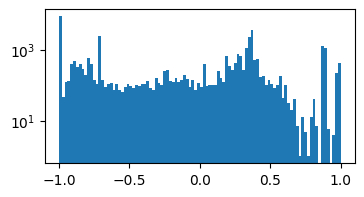

In [35]:
# z histogram
plt.figure(figsize=(4, 2))
plt.hist(z_gen.cpu().detach().numpy().flatten(), bins=100, log=True)
plt.show()

In [36]:
# decode
z_gen = rearrange(z_gen, 'b d h w -> b h w d')
z_gen = trainer.pretrained_vq.project_out(z_gen)
z_gen = rearrange(z_gen, 'b h w d -> b d h w')
print('z_gen.shape:', z_gen.shape)

x_gen = trainer.pretrained_decoder(z_gen)  # (b c h w)
x_gen = x_gen.cpu().detach()
x_gen = x_gen.argmax(dim=1)[:,None,:,:].float()
print('x_gen.shape:', x_gen.shape)

z_gen.shape: torch.Size([9, 64, 32, 32])
x_gen.shape: torch.Size([9, 1, 128, 128])


In [37]:
# plot
save_image(X_cond.argmax(dim=1, keepdim=True), x_gen, 'results/.sample_jupyter_conditional.png')

## Unconditional sampling

In [11]:
num_samples = 9

In [12]:
# sample z
trainer.ema.ema_model.eval()
z_gen = trainer.ema.ema_model.sample(z_q_cond=None, batch_size=num_samples)
print('z_gen.shape:', z_gen.shape)

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

z_gen.shape: torch.Size([9, 4, 32, 32])


In [13]:
# decode
z_gen = rearrange(z_gen, 'b d h w -> b h w d')
z_gen = trainer.pretrained_vq.project_out(z_gen)
z_gen = rearrange(z_gen, 'b h w d -> b d h w')
print('z_gen.shape:', z_gen.shape)

x_gen = trainer.pretrained_decoder(z_gen)  # (b c h w)
x_gen = x_gen.cpu().detach()
x_gen = x_gen.argmax(dim=1)[:,None,:,:].float()
print('x_gen.shape:', x_gen.shape)

z_gen.shape: torch.Size([9, 64, 32, 32])
x_gen.shape: torch.Size([9, 1, 128, 128])


In [14]:
# plot
save_image_unconditional(x_gen, 'results/.sample_jupyter_unconditional.png')

## Transitional Visualization: `x_T` to `x_0`

In [15]:
num_samples = 9

In [16]:
# sample z
trainer.ema.ema_model.eval()
z_gen = trainer.ema.ema_model.sample(z_q_cond=z_q_cond, batch_size=num_samples, return_all_timesteps=True)
print('z_gen.shape:', z_gen.shape)

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

z_gen.shape: torch.Size([9, 1001, 4, 32, 32])


In [17]:
n_transitional_steps = 5
visualizing_steps = np.linspace(0, z_gen.shape[1] - 1, n_transitional_steps).astype(int)
print('visualizing_steps:', visualizing_steps)

for step in visualizing_steps:
    z_gen_ = z_gen[:, step]  # (b c h w)
    
    # decode
    z_gen_ = rearrange(z_gen_, 'b d h w -> b h w d')
    z_gen_ = trainer.pretrained_vq.project_out(z_gen_)
    z_gen_ = rearrange(z_gen_, 'b h w d -> b d h w')

    x_gen = trainer.pretrained_decoder(z_gen_)  # (b c h w)
    x_gen = x_gen.cpu().detach()
    x_gen = x_gen.argmax(dim=1)[:,None,:,:].float()  # (b 1 h w)
    
    save_image(X_cond.argmax(dim=1, keepdim=True), x_gen, f'results/.sample_jupyter_transitional_{step}.png')

visualizing_steps: [   0  250  500  750 1000]


## Conditional sampling given specific `X_cond`

In [15]:
dirname = 'dataset/X_cond'
fnames = os.listdir(dirname)
fnames = [fname for fname in fnames if '_dat' in fname]
fnames = sorted(fnames)

In [16]:
fnames

['facies1003_dat0.csv',
 'facies1003_dat1.csv',
 'facies1003_dat2.csv',
 'facies1003_dat3.csv',
 'facies1003_dat4.csv',
 'facies1017_dat0.csv',
 'facies1017_dat1.csv',
 'facies1017_dat2.csv',
 'facies1017_dat3.csv',
 'facies1017_dat4.csv',
 'facies1071_dat0.csv',
 'facies1071_dat1.csv',
 'facies1071_dat2.csv',
 'facies1071_dat3.csv',
 'facies1071_dat4.csv',
 'facies1144_dat0.csv',
 'facies1144_dat1.csv',
 'facies1144_dat2.csv',
 'facies1144_dat3.csv',
 'facies1144_dat4.csv',
 'facies1257_dat0.csv',
 'facies1257_dat1.csv',
 'facies1257_dat2.csv',
 'facies1257_dat3.csv',
 'facies1257_dat4.csv',
 'facies1280_dat0.csv',
 'facies1280_dat1.csv',
 'facies1280_dat2.csv',
 'facies1280_dat3.csv',
 'facies1280_dat4.csv',
 'facies1404_dat0.csv',
 'facies1404_dat1.csv',
 'facies1404_dat2.csv',
 'facies1404_dat3.csv',
 'facies1404_dat4.csv',
 'facies1420_dat0.csv',
 'facies1420_dat1.csv',
 'facies1420_dat2.csv',
 'facies1420_dat3.csv',
 'facies1420_dat4.csv',
 'facies1455_dat0.csv',
 'facies1455_dat

fname: facies4890_dat3.csv


C:\Users\dslee\anaconda3\envs\geo_diffusion\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  del sys.path[0]


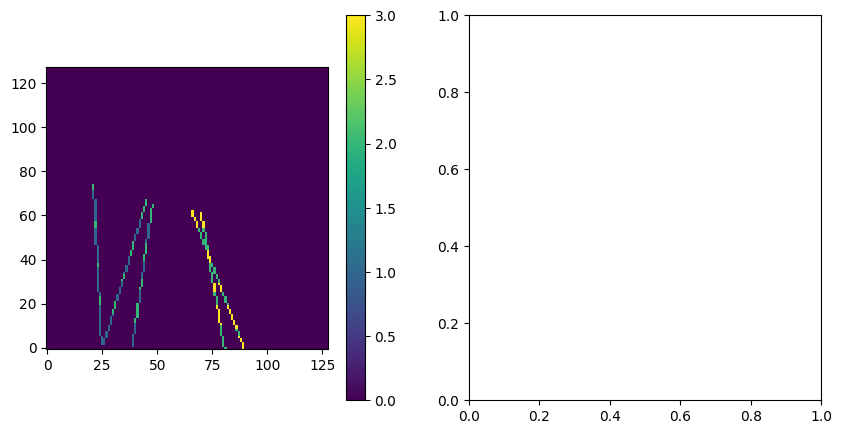

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

In [55]:
fname = 'facies4890_dat3.csv'  #fnames[4]
print('fname:', fname)
x_cond = pd.read_csv(os.path.join(dirname, fname), header=None).values 

# remove the index
x_cond = x_cond[1:, 1:]  # (h w)

# create n channels for n categories
h, w = x_cond.shape
unique_categories = np.array([-1, 0, 1, 2])  #np.unique(x_cond)
x_new = np.zeros((len(unique_categories), h, w))  # (c h w)
for j, c in enumerate(unique_categories):
    x_new[j] = np.array(x_cond == c, dtype=np.float)
x_cond = x_new  # (c h w)

# flip
x_cond = np.flip(x_cond, axis=1)

# plot
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
im = axes[0].imshow(x_cond.argmax(axis=0), interpolation='nearest', vmin=0, vmax=3)
plt.colorbar(im, ax=axes[0])
axes[0].invert_yaxis()
plt.show()

# x_cond
n_samples = 9
x_cond = einops.repeat(x_cond, 'c h w -> b c h w', b=n_samples)  # (b c h w)

# z_q_cond
x_cond = torch.from_numpy(np.array(x_cond)).float()  # (b c h w); b == num_samples
z_cond = trainer.pretrained_encoder_cond(x_cond.to(trainer.accelerator.device))  # (b c h' w')
z_q_cond, _, _, _ = quantize(z_cond, trainer.pretrained_vq_cond, return_z_q_before_proj_out=True)

# sample z
trainer.ema.ema_model.eval()
z_gen = trainer.ema.ema_model.sample(z_q_cond, batch_size=n_samples)

In [56]:
# decode
z_gen = rearrange(z_gen, 'b d h w -> b h w d')
z_gen = trainer.pretrained_vq.project_out(z_gen)
z_gen = rearrange(z_gen, 'b h w d -> b d h w')
print('z_gen.shape:', z_gen.shape)

x_gen = trainer.pretrained_decoder(z_gen)  # (b c h w)
x_gen = x_gen.cpu().detach()
x_gen = x_gen.argmax(dim=1)[:,None,:,:].float()
print('x_gen.shape:', x_gen.shape)

torch.cuda.empty_cache()

z_gen.shape: torch.Size([9, 64, 32, 32])
x_gen.shape: torch.Size([9, 1, 128, 128])


In [57]:
# plot
from denoising_diffusion_pytorch.denoising_diffusion_pytorch import save_image
print('fname:', 'results/.c_{}.png'.format(fname.split('.csv')[0]))
save_image(x_cond.argmax(dim=1, keepdim=True), x_gen, 'results/.c_{}.png'.format(fname.split('.csv')[0]))

fname: results/.c_facies4890_dat3.png


fname_gt: facies4890.csv


C:\Users\dslee\anaconda3\envs\geo_diffusion\lib\site-packages\ipykernel_launcher.py:15: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  from ipykernel import kernelapp as app


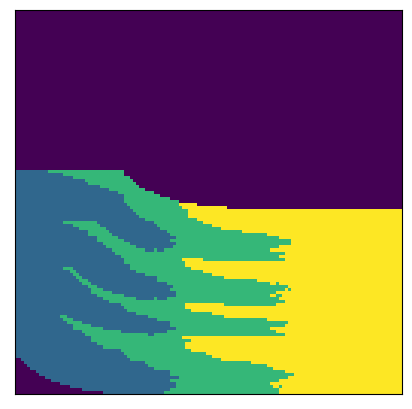

In [58]:
# plot the ground truth

fname_gt = fname.split('_dat')[0] + '.csv'
print('fname_gt:', fname_gt)
x_cond = pd.read_csv(os.path.join(dirname, fname_gt), header=None).values 

# remove the index
x_cond = x_cond[1:, 1:]  # (h w)

# create n channels for n categories
h, w = x_cond.shape
unique_categories = np.array([-1, 0, 1, 2])  #np.unique(x_cond)
x_new = np.zeros((len(unique_categories), h, w))  # (c h w)
for j, c in enumerate(unique_categories):
    x_new[j] = np.array(x_cond == c, dtype=np.float)
x_cond = x_new  # (c h w)

# flip
x_cond = np.flip(x_cond, axis=1)

# plot
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
im = ax.imshow(x_cond.argmax(axis=0), interpolation='nearest', vmin=0, vmax=3)
# plt.colorbar(im, ax=ax)
# axes[0].invert_yaxis()
plt.xticks([])
plt.yticks([])
plt.show()

## Bulk unconditonal sampling 

In [5]:
import pandas as pd

In [14]:
# sample many and save

n_samples = 5000
batch_size = 200

n_iters = np.ceil(n_samples / 256).astype(int)
# for i in range(n_iters):
for i in [20, 21, 22, 23, 24]:
    # sample z
    trainer.ema.ema_model.eval()
    z_gen = trainer.ema.ema_model.sample(batch_size=batch_size)

    # sample x_gen
    z_gen = rearrange(z_gen, 'b d h w -> b h w d')
    z_gen = trainer.pretrained_vq.project_out(z_gen)
    z_gen = rearrange(z_gen, 'b h w d -> b d h w')
    print('z_gen.shape:', z_gen.shape)

    x_gen = trainer.pretrained_decoder(z_gen)  # (b c h w)
    x_gen = x_gen.cpu().detach()
    x_gen = x_gen.argmax(dim=1)[:,None,:,:].float()
    print('x_gen.shape:', x_gen.shape)

    # save
    with open(f'X_gen_20230317_{i}.npy', 'wb') as f:
        np.save(f, x_gen[:, 0, : ,:])
    
    # empty cuda memory
    torch.cuda.empty_cache()

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

z_gen.shape: torch.Size([200, 64, 32, 32])
x_gen.shape: torch.Size([200, 1, 128, 128])


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

z_gen.shape: torch.Size([200, 64, 32, 32])
x_gen.shape: torch.Size([200, 1, 128, 128])


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

z_gen.shape: torch.Size([200, 64, 32, 32])
x_gen.shape: torch.Size([200, 1, 128, 128])


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

z_gen.shape: torch.Size([200, 64, 32, 32])
x_gen.shape: torch.Size([200, 1, 128, 128])


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

z_gen.shape: torch.Size([200, 64, 32, 32])
x_gen.shape: torch.Size([200, 1, 128, 128])


In [11]:
del x_gen

In [12]:
torch.cuda.empty_cache()